# Sktime ARIMA tutorial (firts draft)
### Authors: Andreev Mikhail, Markin Nikita, Lobachev Nikita



## In this notebook one can find the pipline for working with sktime library on the topic of ARIMA model.
### Content of the notebook:


1.   Preparing the environment
2.   Dataset preprocessing
3.   Estimation of one particular ARIMA model with following equation
4.   Estimation of the best model on the basis of autoARIMA function
5.   Visualisation of the archieved results
5.   Evaluation of the models with sliding window
5.   --//--




## Installation of all required packages



In [ ]:
from sktime.utils.plotting import plot_series 
from sktime.forecasting.model_selection import temporal_train_test_split  
from sktime.forecasting.model_selection import ( 
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sg

## Downloading the data in csv format
### Data use in the tutorial is a climate change data about temperature on the earth surface. 
### In the data we use only columns with average temperature around the globe.
Data is available at: 
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [ ]:
df = pd.read_csv('GlobalTemperatures.csv', encoding='utf-8')

### Choose only the columns with date and target variable, the one that will be predicted

In [ ]:
df.drop(["LandMaxTemperature", "LandMaxTemperatureUncertainty",
         "LandMinTemperature", "LandMinTemperatureUncertainty",
         "LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty"],
        axis=1, inplace=True)
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574
1,1750-02-01,3.083,3.702
2,1750-03-01,5.626,3.076
3,1750-04-01,8.490,2.451
4,1750-05-01,11.573,2.072


### Convert date column to the datetime type 
If was not
### We also limit our data sample in order to decrease time spent on fitting


In [ ]:
date_from_which = '1990-01' 
df["dt"] = pd.to_datetime(df["dt"], format='%Y-%m-%d', errors='coerce')
df = df.loc[df['dt']>=date_from_which]
df['dt'] = pd.date_range(start=date_from_which, end='2016-01-01', freq='M')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
2880,1990-01-31,3.243,0.090
2881,1990-02-28,3.643,0.087
2882,1990-03-31,6.730,0.099
2883,1990-04-30,9.169,0.059
2884,1990-05-31,11.831,0.071


### Construct new data entity "y" of type Pandas.Series 

### It will have dates as indices and target variable as a column

#### **It is the cruсial part, because sktime works only with such datatype.**

#### Here to_period() function has "D" as an argument, since iteration is condutced by days

In [ ]:
df["dt"] = pd.to_datetime(df["dt"])
y = pd.Series(df['LandAverageTemperature'].values , index=df['dt'])
y.index = y.index.to_period('M')
y.head()


dt
1990-01     3.243
1990-02     3.643
1990-03     6.730
1990-04     9.169
1990-05    11.831
Freq: M, dtype: float64

## Visualisation of the data divided to test and train parts
#### In this example we know from other sources of information that avarage temperature increases faster in last years. 
#### This information will be helpful for constructing a model

##### We choose test size to be 72 months as it is 6 years. Data under investigation is 25 years. Therefore test set is around 25% of whole sample.

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=72)

## Plot our data
### function plot_series() takes train, test data and their labels. It has a connected graph of observations as an outcome.
##### From the picture we see that the process is stationary and therefore we guess for 0 in the middle of ARIMA parameters.

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff6d6f624d0>)

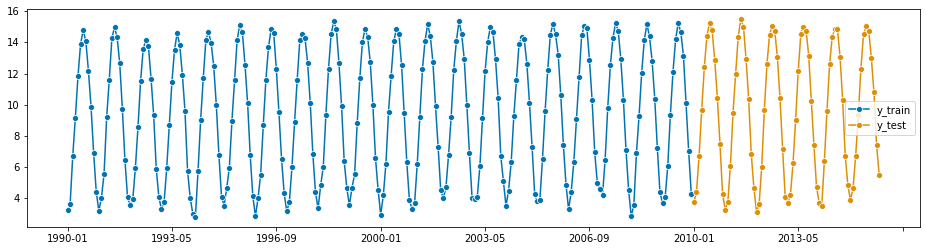

In [ ]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])

From the graph it is clear that data is stationary, so running Dicki Fuller's test is not necessary. It is also clear there is seasonality in this time series.

###Hand picked parameters for Arima model


In order to pick the best parameters, we need to plot Autocorrelation and Partial Autocorrelation for both non-seasonal  and seasonal parts.

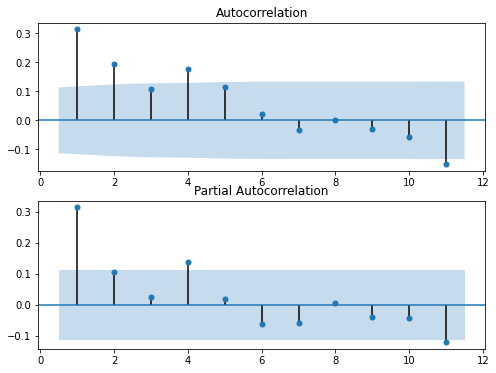

In [ ]:
temp_diff = y.diff(12).dropna()
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
sg.plot_acf(temp_diff, lags=11, zero=False, ax=ax1)
sg.plot_pacf(temp_diff, lags=11, zero=False, ax=ax2)
plt.show()

The graphs are inconsistent, so we cannot make any certain predictions on the parameters. Therefore we are going to use ARIMA(0,0)

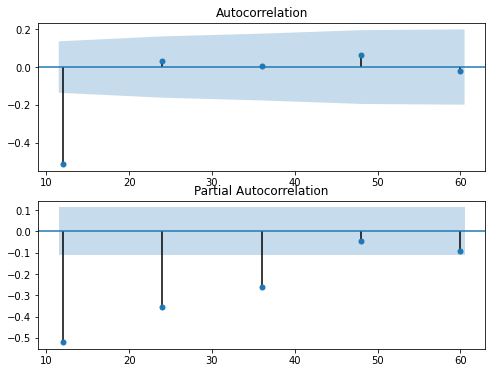

In [ ]:
# Seasonal part

# Make list of lags
lags = [12, 24, 36, 48, 60]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
sg.plot_acf(temp_diff, lags=lags, zero=False, ax=ax1)
sg.plot_pacf(temp_diff, lags=lags, zero=False, ax=ax2)
plt.show()

For the seasonal part we can see the AC cuts-off after first lag, but PAC tails-off. So we should choose MA(1) for this part of model

0.03710517497252466

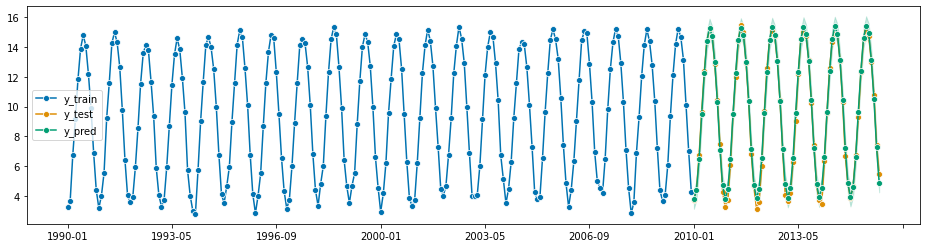

In [ ]:
forecaster = ARIMA(
    order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), suppress_warnings=True
)
forecaster.fit(y_train)
horizon = ForecastingHorizon(y_test.index, is_relative=False)
y_pred, pred_ints = forecaster.predict(horizon, return_pred_int=True, alpha=0.05)
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
smape_loss(y_test, y_pred)

###Now lets visualize only the test part
#### We just delete the y_train from the function plot_series()

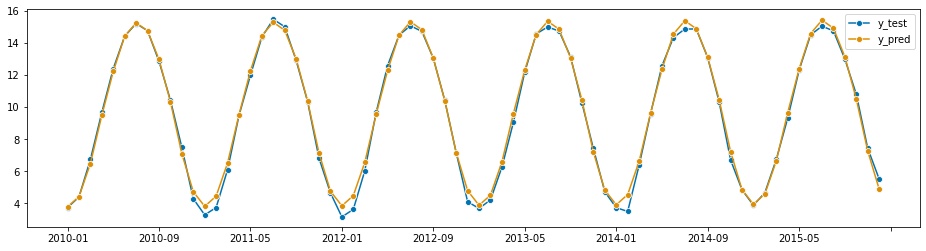

In [ ]:
fig, ax = plot_series(y_test, y_pred,
    labels=["y_test", "y_pred"])             

## All the informatin about the chosen model is accessable in **model.summary()**

In [ ]:
print(forecaster.summary())

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  240
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                 -79.126
Date:                    Wed, 03 Mar 2021   AIC                            164.252
Time:                            20:09:30   BIC                            174.540
Sample:                                 0   HQIC                           168.403
                                    - 240                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0326      0.004      8.532      0.000       0.025       0.040
ma.S.L12      -0.9974      3.045     -0.328      0.743      -6.966       4.971
sigma2         0.100

After series analysis the model we used here was Seasonal Arima with parameters $(0,0,0), (0, 1, 1)_{12}$. 

The general form with such parameters is: $$y_t = m12 \cdot \epsilon_{t-12} + \epsilon_t$$

If we plug in obtained coefficients: $$y_t = -0.9974 \cdot \epsilon_{t-12} + \epsilon_t$$


## Implementing of autoARIMA function
 

#### At first, we define our model by AutoARIMA() with argument auto=True and sp=12 because we have 12 months in a year.

In [ ]:
Auto_arima_model = AutoARIMA(auto=True, sp = 12)

#### Then, we fit model with function fit() and our train data as a parameter. It may take some time =)

In [ ]:
Auto_arima_model.fit(y_train)  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

AutoARIMA(sp=12)

####On the next step we define **ForecastingHorizon** which is the time segment under the scope of the investigation.

In [ ]:
horizon = ForecastingHorizon(y_test.index, is_relative=False)

#### We use 95% predictive interval and predict the value of target variable for dates in the ForecastingHorizon

In [ ]:
y_pred_AUTO, pred_ints = Auto_arima_model.predict(horizon,
               return_pred_int=True, alpha=0.05)    

#### In order to visualize the result we use plot_series() function as before, with data and labels for it. 
#### At the same time we depict predictive intervals with the help of fill_between() function in which we first find out the x values of our prediction and then build predictive interval

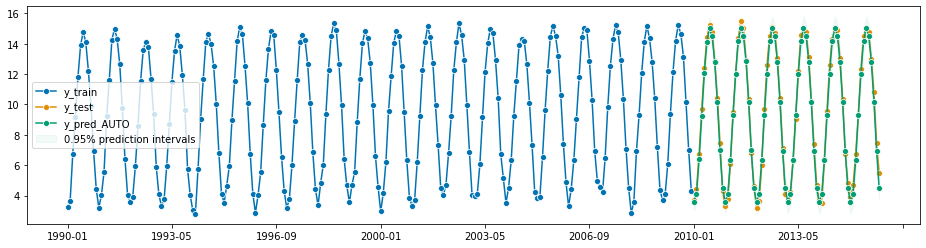

In [ ]:
fig, ax = plot_series(y_train, y_test, y_pred_AUTO,
    labels=["y_train", "y_test", "y_pred_AUTO"])   
ax.fill_between(                                                  
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.05,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

###Now lets visualize only the test part
#### We just delete the y _train from the function plot_series()

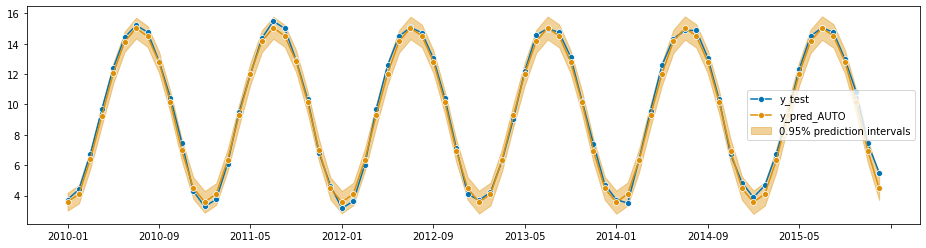

In [ ]:
fig, ax = plot_series(y_test, y_pred_AUTO,
    labels=["y_test", "y_pred_AUTO"])             
ax.fill_between(                                               
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.4,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## In order to compare the results with the test data we use smape_loss

#### Here is the formula for sMAPE or Symmetric mean absolute percentage error. It is one of the many metrics that is used in order to check accuracy.



$$smape(y, \hat y) = \frac{1}{H} \sum_{i=T+1}^{T+H} \frac{|y_i - \hat y_i|}{\frac{|y_i| + |\hat y_i|}{2}}$$


### $y$ is a true response
### $\hat y$ is predicted response 
### $T$ is the observation number where train ends 
### $H$ is a quantity of observations in the test

In [ ]:
print(smape_loss(y_test, y_pred_AUTO))

0.040655252911252465


In [ ]:
Auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                 -59.371
Date:                              Wed, 03 Mar 2021   AIC                            132.741
Time:                                      19:59:28   BIC                            156.747
Sample:                                           0   HQIC                           142.427
                                              - 240                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      0.094     -0.097      0.923      -0.193       0.175
ar.L2          0.8671      0.095      9.139      0.000       0.681       1.053
ma.L1          0.2396      0.119      2.005      0.045       0.005       0.474
ma.L2         -0.5572      0.105     -5.314      0.000      -0.763      -0.352
ar.S.L12      -0.1916      0.075     -2.554      0.011      -0.339      -0.045
ma.S.L12      -0.8585      0.087     -9.874      0.000      -1.029      -0.688
sigma2         0.0906      0.008     10.722      0.000       0.074       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.70   Prob(JB):                         0.37
Heteroskedasticity (H):               1.05   Skew:                            -0.12
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using auto fitting we obtained model with parameters $(2, 0, 2), (1, 1, 1)_{12}$. 

The general form with such parameters is: $$y_t = a1 \cdot y_{t-1} + a2 \cdot y_{t-2} + m1 \cdot \epsilon_{t-1} + m2 \cdot \epsilon_{t-2} + a12 \cdot y_{t-12} + m12 \cdot \epsilon_{t-12} + \epsilon_t$$

If we plug in obtained coefficients: $$y_t = -0.0091 \cdot y_{t-1} + 0.8671 \cdot y_{t-2} + 0.2396 \cdot \epsilon_{t-1} -0.5572 \cdot \epsilon_{t-2} -0.1916 \cdot y_{t-12} -0.8585 \cdot \epsilon_{t-12} + \epsilon_t$$


# Our model vs autoArima model?

Now we want to compare which model is better: the one with the hand picked parameters or the one suggested by autoArima. We can do it by comparing sMAPE, the model with lower sMAPE is considered to be better. Recall that for the first model we got sMAPE equal to approximately $0.0371$, and for the second $0.0406$. So, based on that we can coclude that hand picked parameters $(0,0,0), (1, 1, 1)_{12}$ showed better results.

## Finally, lets compare some models using Sliding Window

Now lets compare some models using sliding window. Sliding window is realised by function SlidingWindowSplitter and for choosing the model we will use ForecastingGridSearchCV, which goes through specified parameters and calculates the sMAPE(or other specified scoring) for each.

In [ ]:
cv = SlidingWindowSplitter(
    initial_window=int(len(y) * 0.3),
)

orders = [(0, 0, 1),
          (0, 0, 0),
          (2, 0, 2)]

seasonal_orders = [(0, 1, 1, 12),
                   (1, 1, 1, 12),]

forecaster_param_grid = {"order": orders, "seasonal_order": seasonal_orders}
forecaster = ARIMA(suppress_warnings=True)

gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True,
)
gscv.fit(y)

Fitting 312 folds for each of 6 candidates, totalling 1872 fits


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7ff6e25bba50>,
                        forecaster=ARIMA(suppress_warnings=True),
                        param_grid={'order': [(0, 0, 1), (1, 0, 0), (2, 0, 2)],
                                    'seasonal_order': [(0, 1, 1, 12),
                                                       (1, 1, 1, 12)]},
                        verbose=True)

Now we can get the model with lowest sMAPE, using attribute best_forecaster:

In [ ]:
gscv.best_forecaster_

ARIMA(seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

Again, we got that best model is Seasonal Arima with parameters $(0,0,0), (1, 
1, 1)_{12}$. It outperformed random models and the model suggested by autoArima.